In [1]:
from mr_tools import fit_line as fl
import numpy as np
import matplotlib.pyplot as plt

import pickle
structure = pickle.load(open('Timings_npsf=41.pkl', 'rb'))
structure_sinc = pickle.load(open('Timings_sinc_npsf=41.pkl', 'rb'))

#Reading results
n_hrs = np.array(structure['n_hr'])
n_lrs = np.array(structure['n_lr'])
s_mean = (np.array(structure['s_mean']))
s_std = np.array(structure['s_std'])
g_mean = np.array(structure['g_mean'])
g_std = np.array(structure['g_std'])
gs_mean = np.array(structure_sinc['gs_mean'])
gs_std = np.array(structure_sinc['gs_std'])

s = np.argsort(n_lrs)
s_mean = s_mean[s]
s_std = s_std[s]
g_mean = g_mean[s]
g_std = g_std[s]
n_lrs = n_lrs[s]


def evaluate_on_grid(func, a_grid, b_grid, args=()):
    a_grid,b_grid = np.meshgrid(a_grid, b_grid)
    ab_grid = np.vstack((a_grid.ravel(), b_grid.ravel())).T
    
    func_vals = np.zeros(ab_grid.shape[0])
    for j,pars in enumerate(ab_grid):
        func_vals[j] = func(pars, *args)
        
    return func_vals.reshape(a_grid.shape)
def line_model(pars, x):
    return pars[0]*x + pars[1]

# Timing fit
stdy_y = np.sqrt(np.sum((s_std/s_mean)**2 + (g_std/g_mean)**2))
stdy_sy = np.sqrt(np.sum((gs_std/gs_mean)**2 + (g_std/g_mean)**2))


/Users/remy/opt/anaconda3/lib/python3.8/site-packages/proxmin-0.6.11-py3.8.egg/proxmin/nmf.py:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if W is 1:


In [2]:
p0 = [1, 0., 0.]
scatter_model = fl.StraightLineIntrinsicScatterModel(n_lrs, s_mean/g_mean, stdy_y*np.abs(s_mean/g_mean), line_model)
chain,_,acc_frac = fl.run_metropolis_hastings(p0, n_steps=2**16, model=scatter_model, 
                                           proposal_sigmas=[0.5,0.5,0.2])
acc_frac

0.0102691650390625

No handles with labels found to put in legend.


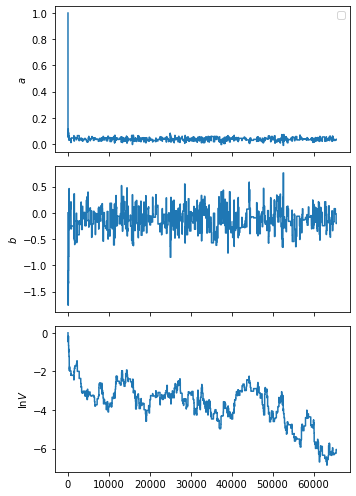

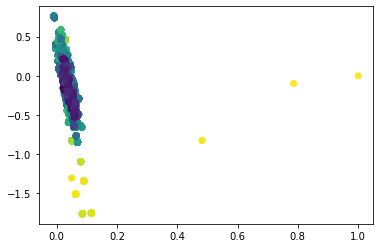

In [3]:
fig,axes = plt.subplots(len(p0), 1, figsize=(5,7), sharex=True)

for i in range(len(p0)):
    axes[i].plot(chain[:,i], marker='', drawstyle='steps')
    
axes[0].legend(loc='best')
axes[0].set_ylabel('$a$')

axes[1].set_ylabel('$b$')

axes[2].set_ylabel(r'$\ln V$')

fig.tight_layout()

plt.show()

plt.scatter(chain[:,0], chain[:,1], c = chain[:,-1])
plt.show()


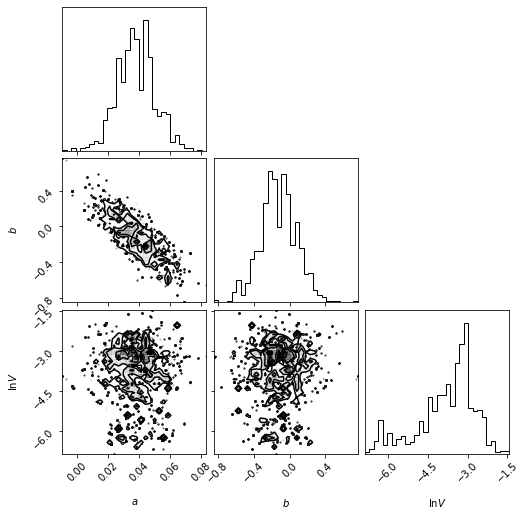

In [4]:
import corner
fig = corner.corner(chain[2000:], bins=32, labels=['$a$', '$b$', r'$\ln V$'], 
                    )

In [5]:
good_samples = chain[2000::8]


In [6]:
low,med,hi = np.percentile(good_samples, [16, 50, 84], axis=0)
upper, lower = hi-med, med-low
from IPython import display
disp_str = ""
for i,name in enumerate(['a', 'b', r'\ln V']):
    fmt_str = '{name}={val:.5f}^{{+{plus:.5f}}}_{{-{minus:.5f}}}'
    disp_str += fmt_str.format(name=name, val=med[i], plus=upper[i], minus=lower[i])
    disp_str += r'\quad '
    
disp_str = "${}$".format(disp_str)
display.Latex(data=disp_str)


<IPython.core.display.Latex object>

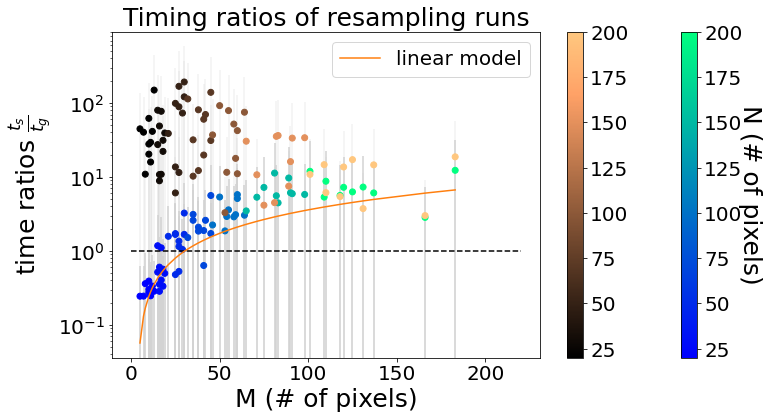

In [7]:
#Timing ratios as a function of M
fig2, ax2 = plt.subplots(figsize=(12, 6))
plt.errorbar(n_lrs, s_mean/g_mean, yerr = stdy_y*np.abs(s_mean/g_mean), 
             fmt =' ', 
             ecolor='lightgray', zorder = -1)
ax2.plot([0,220], [1,1], '--k')

ax2.plot(n_lrs, med[0]*n_lrs + med[1], label = 'linear model')

plt.errorbar(n_lrs, gs_mean/g_mean, 
             yerr = stdy_sy*np.abs(gs_mean/g_mean), 
             fmt =' ', 
             ecolor='lightgray', 
             alpha=0.3,
             zorder = -1)




# Adding plotting parameters
ax2.set_title('Timing ratios of resampling runs', fontsize=25)
ax2.set_xlabel('M (# of pixels)', fontsize=25)
ax2.set_ylabel('time ratios $\\frac{t_s}{t_g}$', fontsize=25)

ax2.semilogy()


#ax2.cbar.set_label('N (# of pixels)', rotation=270, fontsize = 25, labelpad = 20)

sc1 = ax2.scatter(n_lrs, s_mean/g_mean,c = n_hrs[::-1], marker = 'o', cmap = 'winter', zorder = 1)
ax2.cbar = plt.colorbar(sc1)
ax2.cbar.set_label('N (# of pixels)', rotation=270, fontsize = 25, labelpad = 20)
ax2.cbar.ax.tick_params(labelsize=20)

sc2 = ax2.scatter(n_lrs, gs_mean/g_mean,c = n_hrs[::-1], marker = 'o', cmap = 'copper', zorder = 1)
ax2.cbar2 = plt.colorbar(sc2)
ax2.cbar2.ax.tick_params(labelsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.savefig('galsim_scarlet_ratio.png')
plt.show()
